# Randomly Generated Points

Finding patterns that arise in a randomly generated set of points.

Focus: Euclidean distance

First, plot the points on a scatter plot

Then, make a heatmap of distances

Then, use MDS (Multidimensional Scaling) & overlay with OG plot.

The goal is to see patterns that arise in randomly-generated **clusters** of points.


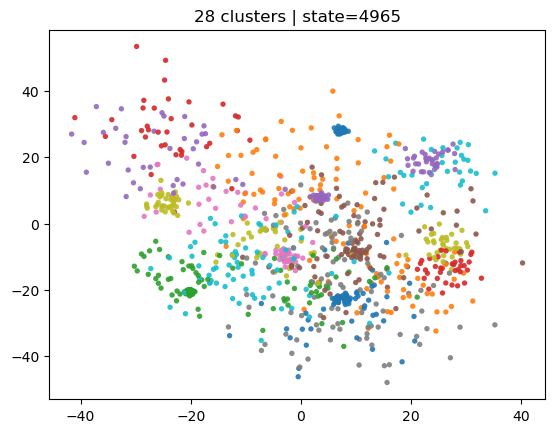

In [247]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt
import numpy as np
import random

# --- Parameters ---
s = 1000  # total samples
min_clusters = 5
max_clusters = 30
n_features = 2
random_state = random.randint(1, 9999)

# --- Random settings ---
c = random.randint(min_clusters, max_clusters)
centers = np.random.uniform(low=-30, high=30, size=(c, n_features))
cluster_std = np.random.uniform(0.5, 10.0, size=c)

# --- Generate data ---
X, y = make_blobs(
    n_samples=s,
    centers=centers,
    cluster_std=cluster_std,
    random_state=random_state
)


# --- Plot ---
plt.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=15, edgecolors='none', alpha=0.9)  # auto-color by cluster label
plt.title(f"{c} clusters | state={random_state}")
plt.show()


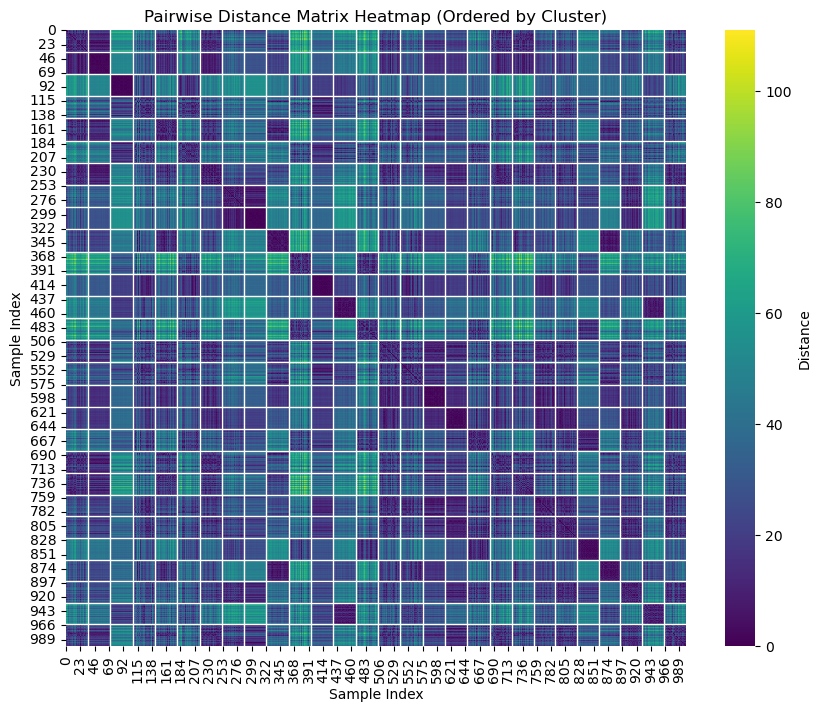

In [248]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns  # For nicer heatmaps
import sys

sys.path.append('..')
from distances.distance_matrix import make_distance_matrix

df = pd.DataFrame(X, columns=[f"feature_{i}" for i in range(X.shape[1])])
df['label'] = y

dist_matrix = make_distance_matrix(X, metric='euclidean')  # X is already numpy array

order = np.argsort(y)
M = dist_matrix[np.ix_(order, order)]

plt.figure(figsize=(10, 8))
sns.heatmap(M, cmap='viridis', cbar_kws={'label': 'Distance'})
plt.title("Pairwise Distance Matrix Heatmap (Ordered by Cluster)")
plt.xlabel("Sample Index")
plt.ylabel("Sample Index")

# Draw cluster boundary lines (white lines for separation, like in Iris)
y_ordered = y[order]
bounds = np.where(y_ordered[:-1] != y_ordered[1:])[0] + 0.5
for b in bounds:
    plt.axhline(b, color='white', linewidth=1)
    plt.axvline(b, color='white', linewidth=1)

plt.show()


C:\Users\varak\AppData\Local\Temp\ipykernel_26868\4231169600.py:50: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x="cluster", y="displacement", data=df_disp, palette='tab10', ax=ax1)


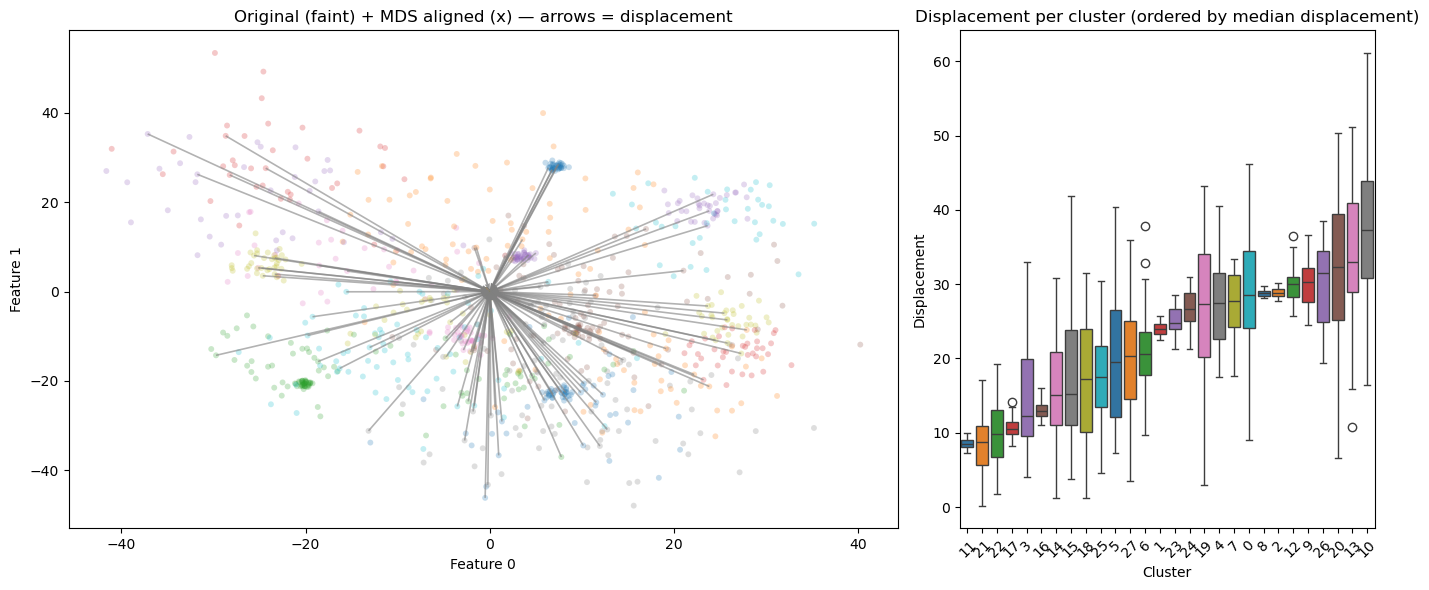

In [253]:
# ...existing code...

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from scipy.spatial import procrustes
import pandas as pd

# ensure dist_matrix exists (compute if not)
try:
    dist_matrix
except NameError:
    from distances.distance_matrix import make_distance_matrix
    dist_matrix = make_distance_matrix(X, metric='euclidean')

# 1) MDS from precomputed distances and align to original coordinates
mds = MDS(n_components=2, dissimilarity='precomputed', random_state=42, max_iter=300, n_init=4)
X_mds = mds.fit_transform(dist_matrix)
_, X_mds_aligned, _ = procrustes(X, X_mds)

# 2) per-point displacement (how far embedding moved each point)
displacements = np.linalg.norm(X - X_mds_aligned, axis=1)

# 3) order clusters by median displacement to reveal "within-cluster order"
labels = np.unique(y)
medians = [np.median(displacements[y == lab]) for lab in labels]
ordered_labels = labels[np.argsort(medians)]

# Prepare DataFrame for plotting boxplot in that order
df_disp = pd.DataFrame({"cluster": pd.Categorical(y, categories=ordered_labels, ordered=True),
                        "displacement": displacements})

# 4) Plot: left = overlay (original faint + aligned MDS + arrows for subset), right = ordered boxplot
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(14, 6), gridspec_kw={"width_ratios": [2, 1]})

# overlay
ax0.scatter(X[:, 0], X[:, 1], c=y, cmap='tab10', s=18, alpha=0.25, edgecolors='none')
ax0.scatter(X_mds_aligned[:, 0], X_mds_aligned[:, 1], c=y, cmap='tab10', marker='x', s=30, linewidths=0.8)
# use quiver for compact displacement arrows (subset to avoid clutter)
subset = np.random.choice(len(X), size=min(100, len(X)), replace=False)
dx = X_mds_aligned[subset, 0] - X[subset, 0]
dy = X_mds_aligned[subset, 1] - X[subset, 1]
ax0.quiver(X[subset, 0], X[subset, 1], dx, dy, angles='xy', scale_units='xy', scale=1,
           color='gray', alpha=0.6, width=0.002)
ax0.set_title("Original (faint) + MDS aligned (x) — arrows = displacement")
ax0.set_xlabel("Feature 0"); ax0.set_ylabel("Feature 1")

# boxplot showing ordered clusters (illustrates within-cluster order)
sns.boxplot(x="cluster", y="displacement", data=df_disp, palette='tab10', ax=ax1)
ax1.set_title("Displacement per cluster (ordered by median displacement)")
ax1.set_xlabel("Cluster"); ax1.set_ylabel("Displacement")
ax1.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()
